In [4]:
import multiresolutionimageinterface as mir
import openslide
import numpy as np
import skimage
import matplotlib.pyplot as plt

In [82]:
mr_image = reader.open('./5.tif')
level = 2
ds = mr_image.getLevelDownsample(level)

In [94]:
image_patch = mr_image.getUCharPatch(int(2568 * ds), int(5732 * ds), 1300, 1200, level)

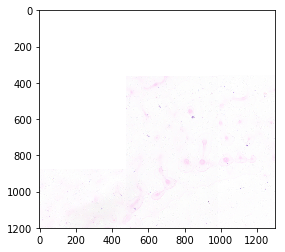

In [95]:
plt.imshow(image_patch)

In [5]:

slide = openslide.OpenSlide('./5.tif')

In [99]:
208796 / slide.level_dimensions[7][1] * abs(minr- maxr)

23171.10729613734

In [71]:
slide.level_count

9

In [70]:
slide.dimensions

(89262, 208796)

In [6]:
slide.level_dimensions

((89262, 208796),
 (44631, 104398),
 (22315, 52199),
 (11157, 26099),
 (5578, 13049),
 (2789, 6524),
 (1394, 3262),
 (697, 1631),
 (348, 815))

In [7]:
thumb = slide.get_thumbnail(slide.level_dimensions[7])


In [73]:
thumb.save??

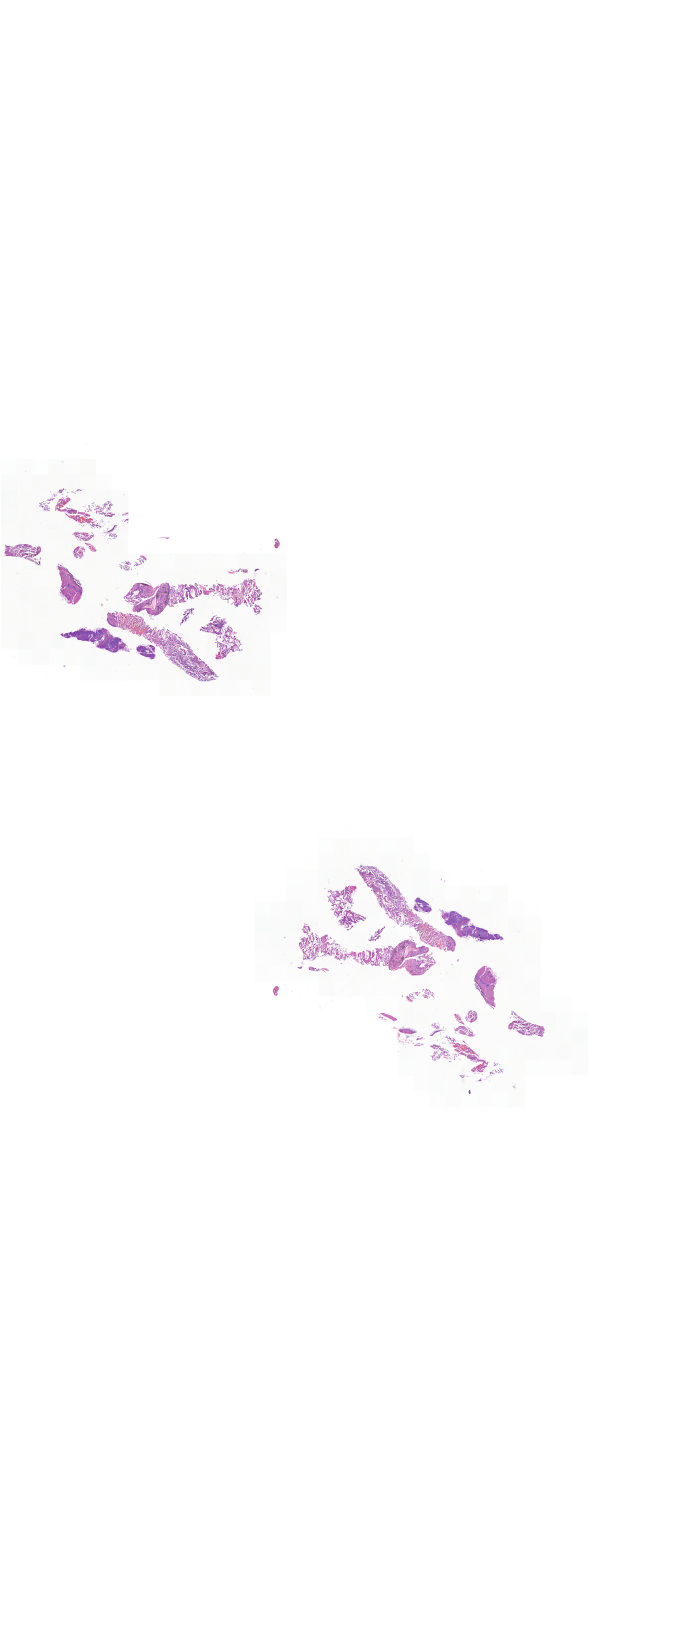

In [8]:
thumb

In [72]:
thumb_gray = skimage.color.rgb2gray(np.array(thumb))

In [10]:
coins = 1. - thumb_gray

In [11]:
np.unique(coins)

array([0.00000000e+00, 2.82745098e-04, 5.65490196e-04, ...,
       7.36601961e-01, 7.43689804e-01, 7.70761961e-01])

Text(0.5, 1.0, 'histogram of grey values')

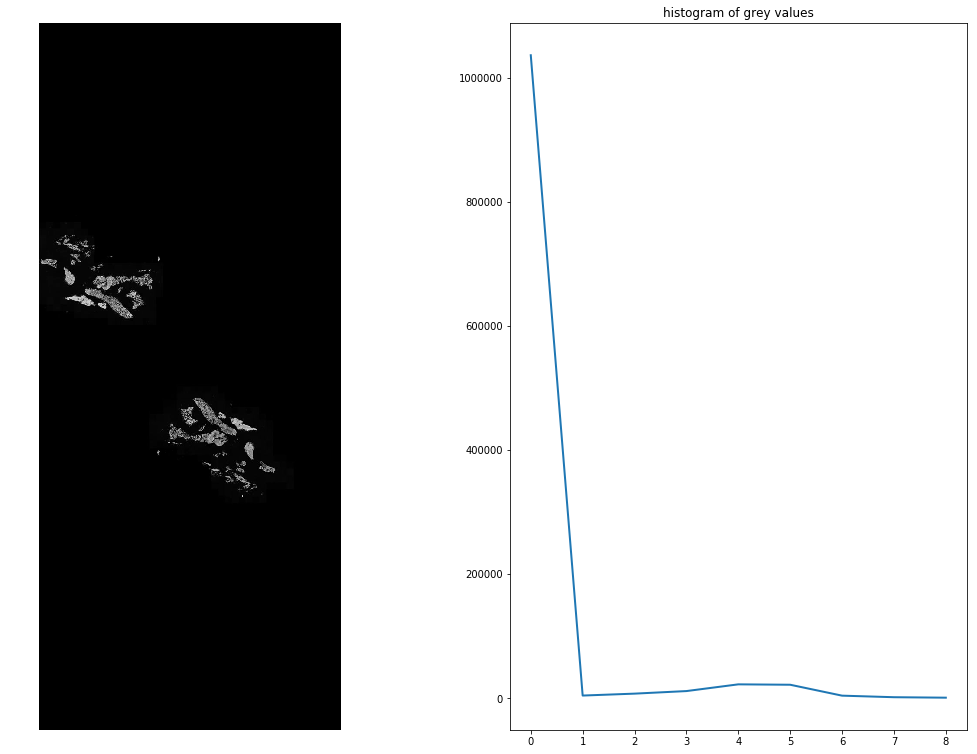

In [12]:
hist = np.histogram(coins * 255., bins=np.arange(0, 10))

plt.figure(figsize=(18, 13))
plt.subplot(121)
plt.imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.subplot(122)
plt.plot(hist[1][:-1], hist[0], lw=2)
plt.title('histogram of grey values')

Text(0.5, 1.0, 'elevation_map')

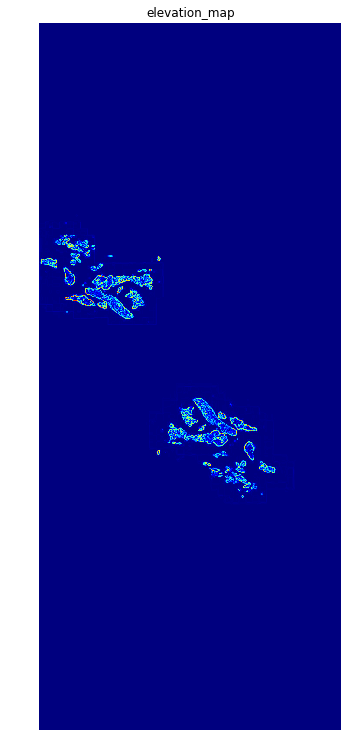

In [13]:
from skimage.filters import sobel

elevation_map = sobel(coins)

plt.figure(figsize=(14, 13))
plt.imshow(elevation_map, cmap=plt.cm.jet, interpolation='nearest')
plt.axis('off')
plt.title('elevation_map')

Text(0.5, 1.0, 'markers')

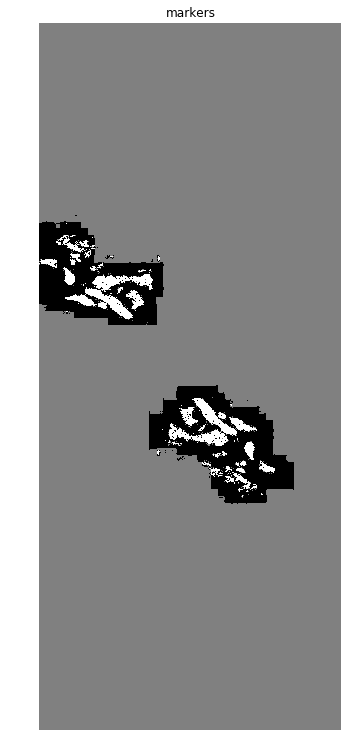

In [25]:
markers = np.zeros_like(coins)
markers[coins <= 1/255.] = 1
markers[coins >= 15/255.] = 2

plt.figure(figsize=(14, 13))
plt.imshow(markers, interpolation='nearest', cmap=plt.cm.gray)
plt.axis('off')
plt.title('markers')

In [16]:
from skimage import morphology, measure

Text(0.5, 1.0, 'segmentation')

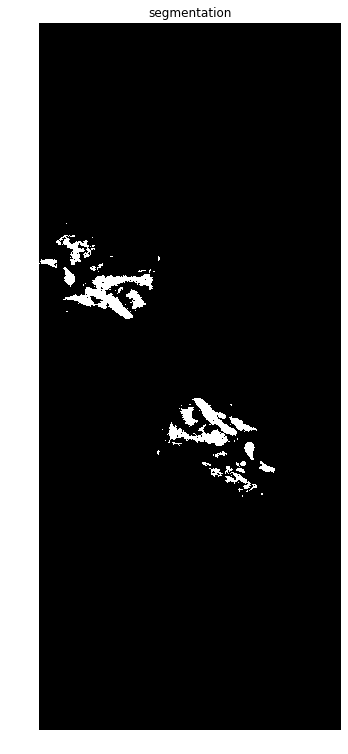

In [28]:
from skimage.morphology import watershed
segmentation = watershed(elevation_map, markers)
# segmentation = morphology.remove_small_objects(segmentation)
plt.figure(figsize=(14, 13))
plt.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('segmentation')

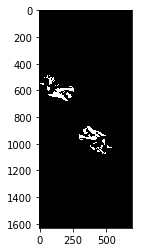

In [29]:
segmentation = ndimage.binary_fill_holes(segmentation - 1)
segmentation = morphology.remove_small_objects(segmentation)
plt.imshow(segmentation, cmap=plt.cm.gray)

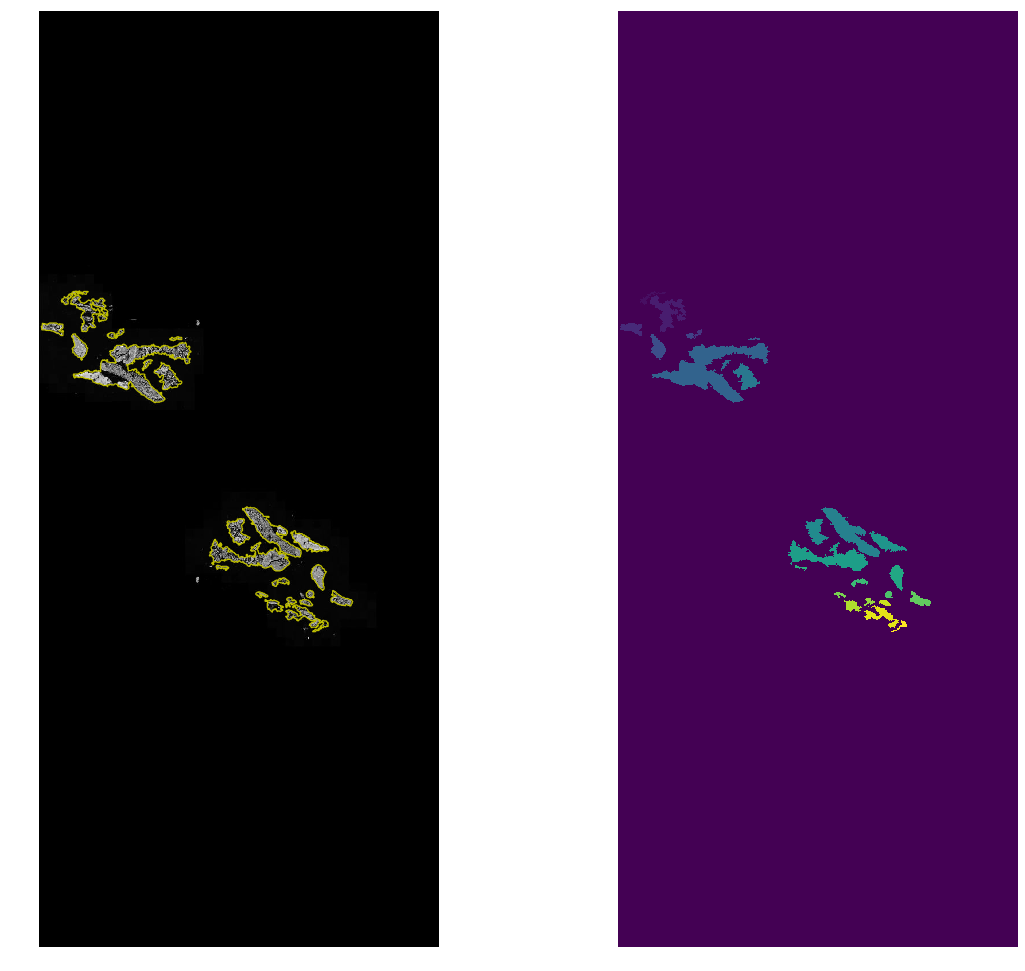

In [24]:
from scipy import ndimage
segmentation = ndimage.binary_fill_holes(segmentation - 1)
segmentation = morphology.remove_small_objects(segmentation)
labeled_coins, _ = ndimage.label(segmentation)

plt.figure(figsize=(16, 13))
plt.subplot(121)
plt.imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
plt.contour(segmentation, [0.5], linewidths=1.2, colors='y')
plt.axis('off')
plt.subplot(122)
plt.imshow(labeled_coins, interpolation='nearest')
plt.axis('off')
margins = dict(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.subplots_adjust(**margins)

In [65]:
mask = thumb_gray != 1

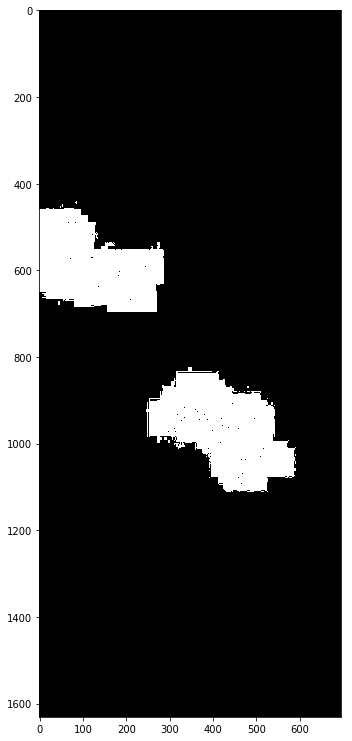

In [66]:
plt.figure(figsize=(14, 13))
plt.imshow(mask, cmap=plt.cm.gray)

In [67]:
from skimage import morphology, measure

In [68]:
np.unique(convx)

array([False,  True])

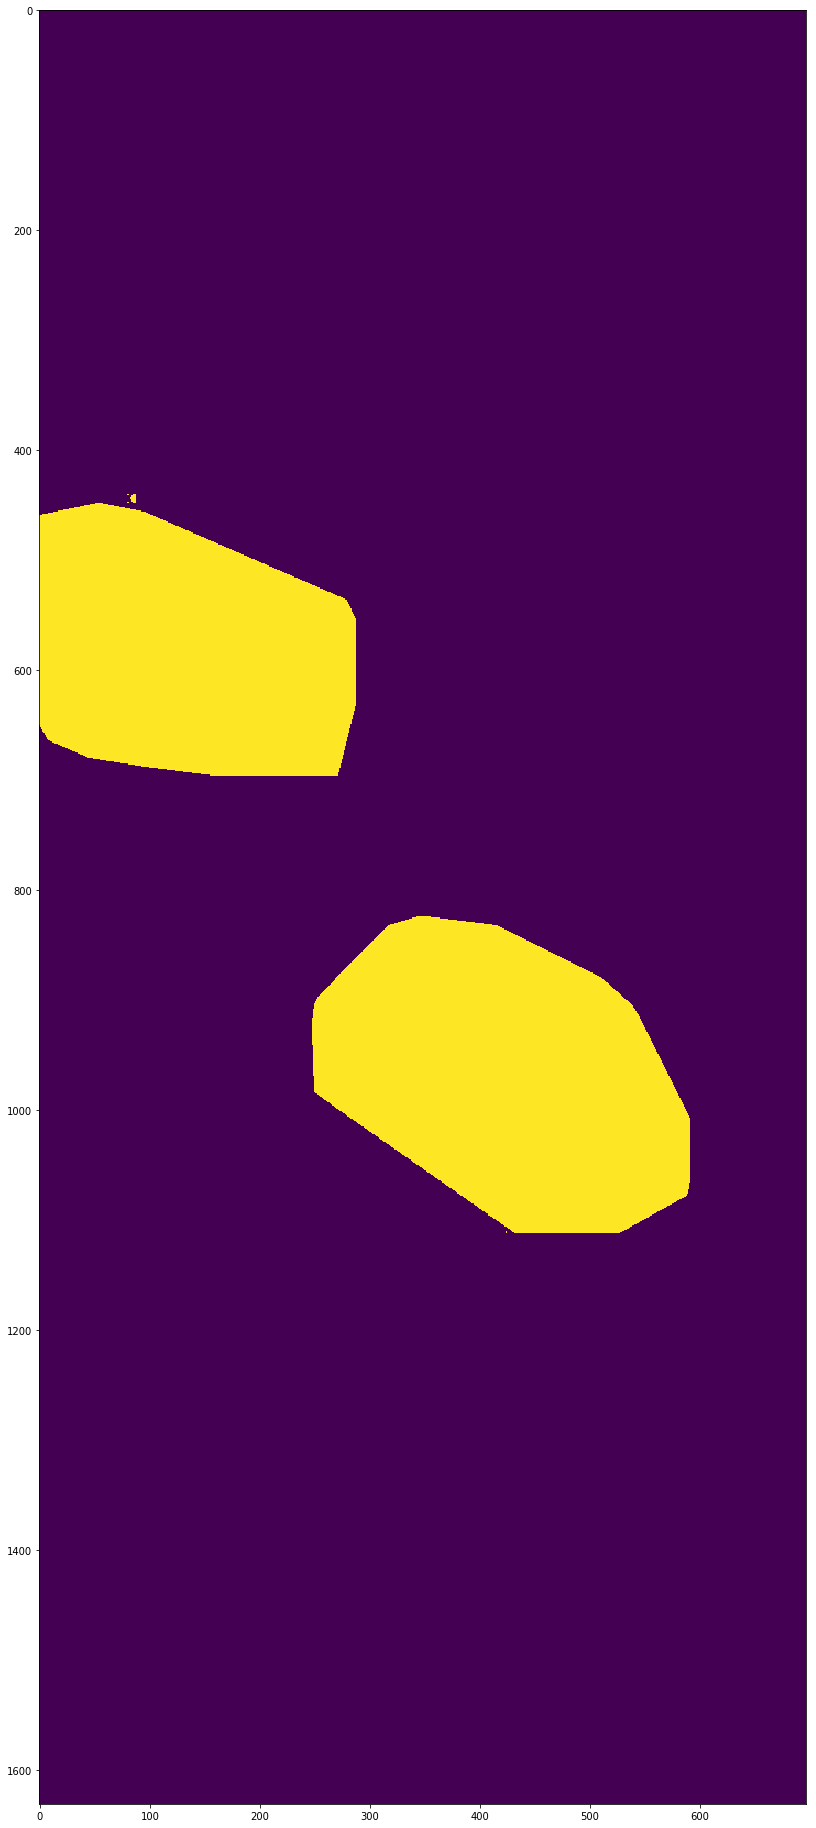

In [69]:
mask = morphology.binary_dilation(mask)
mask = morphology.binary_erosion(mask)
convx = morphology.convex_hull_object(mask)
plt.figure(figsize=(14, 33))
plt.imshow(convx)

In [54]:
mask = morphology.remove_small_holes(convx)
mask = morphology.remove_small_objects(mask)

In [38]:
import matplotlib.patches as mpatches

In [62]:
label_image = measure.label(mask)

In [63]:
image_label_overlay = skimage.color.label2rgb(label_image, image=mask)

(452, 0, 697, 289)
(823, 247, 1113, 591)


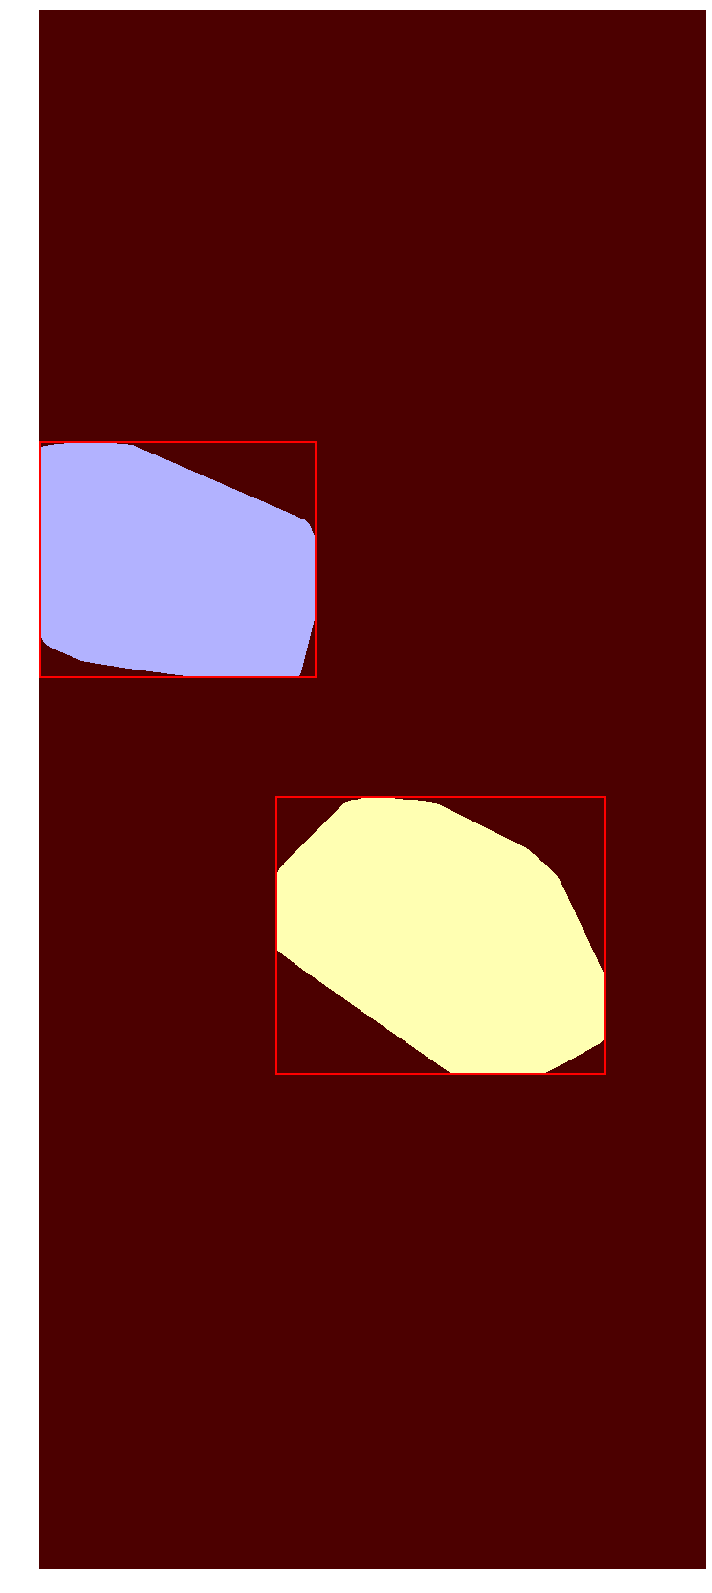

In [64]:
fig, ax = plt.subplots(figsize=(10, 33))
ax.imshow(image_label_overlay)

for region in measure.regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        print(region.bbox)
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()